# FDW Crop Production Data Analysis - Liberia

In [1]:
import json, requests
from functools import reduce
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## Validation with FAO-STAT

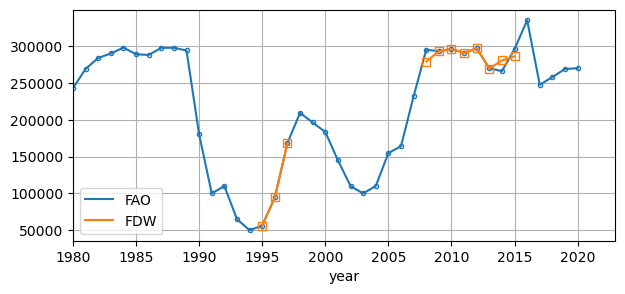

In [11]:
#%% Validation with FAO-STAT national production data
# Load GSCD crop data -------------------------------- # 
country_iso, country_name, product_name_fdw, product_name_fao = 'LR', 'Liberia', 'Rice', 'Rice'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['product'] == product_name_fdw) &
    (df['indicator'] == 'production')
]
df['year'] = df['harvest_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fao, data_fdw], axis=1, keys=['FAO','FDW']).sort_index()
ax = data.plot(xlim=[1980,2023],figsize=[7,3],grid=True, markerfacecolor='None')
marker = ['.','s']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker[i])

## Validation with CHIRPS Precipitation

Main-Rice Correlation:
           FDW      PRCP
FDW   1.000000 -0.281831
PRCP -0.281831  1.000000


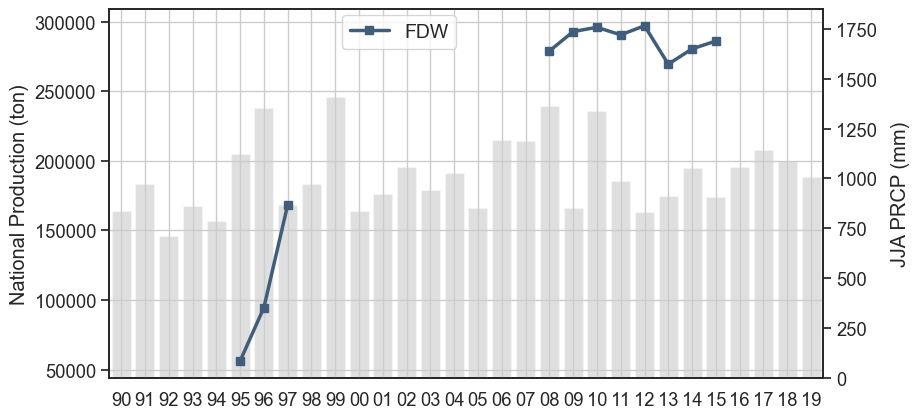

In [15]:
#%% Correlation with growing season CHIRPS precipitation
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'LR', 'Liberia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
season_name, product_name, prcp_start_month, prcp_season_name = 'Main', 'Rice', 6, 'JJA PRCP (mm)'
df = df[
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
df['year'] = df['harvest_year']
data = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp.index = pd.to_datetime(prcp.index)
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name} Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1990,2020)
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(9,4))
data = data.reindex(np.arange(data.index[0],data.index[-1]+1))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #